## CSE 544: Probability & Statistics for Data Science – Spring 2025  
**Instructor:** Anshul Gandhi  
**Project Type:** Mini Group Project – Semester-end submission

### Group Information  
**Group Submitter:** Abhishek Kohli (SBU ID: 116652139)  
**Group Members:**  
- Dhruv Kunjadiya (SBU ID: 116248529)  
- Divyaank Tiwari (SBU ID: 115765038)  
- Harshil Snehalkumar Sanghvi (SBU ID: 115381322)

**Data Split Used:** `split_03.csv`

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest, norm, ks_2samp, ttest_ind
import numpy as np
import itertools as it
import re
from tabulate import tabulate

In [2]:
df = pd.read_csv('split_03.csv')

In [3]:
df.head()

,legId,searchDate,flightDate,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,isBasicEconomy,isRefundable,...,segmentsArrivalTimeEpochSeconds,segmentsArrivalTimeRaw,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode
0,980370cf27c89b40d2833a1d5afc9751,2022-04-16,2022-04-17,ATL,BOS,LA0NX0MC,PT2H34M,0,False,False,...,1650213180,2022-04-17T12:33:00.000-04:00,BOS,ATL,Delta,DL,Airbus A321,9240,947,coach
1,43eaa7e045b3e8a3157e5e38a31696c9,2022-04-16,2022-04-17,ATL,BOS,HA0QA0MQ,PT2H35M,0,False,False,...,1650243840,2022-04-17T21:04:00.000-04:00,BOS,ATL,Delta,DL,Airbus A321,9300,947,coach
2,dc2eda19b0499170f1f7f8c5a179ac07,2022-04-16,2022-04-17,ATL,CLT,M0AHZNN1,PT1H22M,0,False,False,...,1650238620,2022-04-17T19:37:00.000-04:00,CLT,ATL,American Airlines,AA,Canadian Regional Jet 700,4920,228,coach
3,4cf3ae8112e707a55d98c1fcd488c7b4,2022-04-16,2022-04-17,ATL,DEN,QA0NA0MQ,PT3H17M,0,False,False,...,1650244500,2022-04-17T19:15:00.000-06:00,DEN,ATL,Delta,DL,Airbus A321,11820,1207,coach
4,ba84d3c3f0a54f0016d23774182b1150,2022-04-16,2022-04-17,ATL,DEN,QA0NA0MQ,PT3H20M,0,False,False,...,1650258000,2022-04-17T23:00:00.000-06:00,DEN,ATL,Delta,DL,Airbus A321,12000,1207,coach


## Part A: Speed Differences Across Airlines, Airplanes, and Routes

In this section, we aim to explore questions such as:
- Are American Airlines flights slower than Delta flights?
- Are Boeings faster than Airbuses?

To answer these, we will analyze average speeds of flights using the provided dataset (specifically subset chosen by our group).

---

### (i) Dataset Preprocessing

We restrict our analysis to **non-stop flights only**.

We construct a new dataset with the following columns:
- `Distance` (in miles)
- `Duration` (in hours)
- `Airline`
- `Airplane Type`
- A new column `Speed` calculated as (will be in mph):

$$
\text{Speed} = \frac{\text{Distance}}{\text{Duration}}
$$

In [4]:
# consider only nonstop flights
nonstop_df = df[df['isNonStop']]

In [5]:
# create new dataset listing distance, duration, airline, and airplane type for all non-stop flights
cols = {
    'totalTravelDistance': 'Distance',
    'travelDuration': 'Duration',
    'segmentsAirlineName': 'Airline',
    'segmentsEquipmentDescription' : 'Airplane Type'
}
nonstop_df = nonstop_df.rename(columns=cols)
# keep only the columns we want
nonstop_df = nonstop_df[cols.values()]


In [6]:
# this function converts the ISO 8601 duration format to hours
# e.g. PT1H30M -> 1.5
def parse_duration(s):
    match = re.match(r'PT(?:(\d+)H)?(?:(\d+)M)?', s)
    if match:
        hours = int(match.group(1)) if match.group(1) else 0
        minutes = int(match.group(2)) if match.group(2) else 0
        return hours + minutes / 60
    return None

nonstop_df['Duration'] = nonstop_df['Duration'].apply(parse_duration) # converting duration to hours

In [7]:
nonstop_df['Speed'] = nonstop_df['Distance'] / nonstop_df['Duration'] # calculating speed - it will be in miles per hour

In [8]:
nonstop_df.dropna(subset=['Distance', 'Duration', 'Speed'], inplace=True) # dropping rows with missing values

#### Handling Repetitions – What We Decided

As mentioned in the question, we expect two kinds of duplicates in the dataset:

- **Exact duplicates**: rows where distance, duration, airline, and airplane type are all identical.
- **Near duplicates**: rows with the same airline, airplane type, and route, but with slightly different distances or durations.

Our goal in this part of the project is to examine differences in flight speeds across airlines and airplane types. To do that, we want to capture the actual distribution of flight speeds - not just the averages.

So, if the same airline and airplane type appear multiple times with slightly different speeds, we consider that variation to be real and important for the analysis. We don’t want to lose that by averaging or dropping those rows.

**Final decision**:  
We kept all records, including repeated ones, because our focus is on the full distribution of speeds (mean, variance, etc.). The only exception is exact duplicates - we removed those to avoid unnecessary redundancy in the dataset.

In [9]:
nonstop_df.drop_duplicates(inplace=True) # dropping exact duplicates

In [10]:
nonstop_df_final = nonstop_df[['Distance', 'Duration', 'Airline', 'Airplane Type', 'Speed']]

In [11]:
nonstop_df_final.head()

,Distance,Duration,Airline,Airplane Type,Speed
0,947.0,2.566667,Delta,Airbus A321,368.961039
1,947.0,2.583333,Delta,Airbus A321,366.580645
2,228.0,1.366667,American Airlines,Canadian Regional Jet 700,166.829268
3,1207.0,3.283333,Delta,Airbus A321,367.614213
4,1207.0,3.333333,Delta,Airbus A321,362.100000


### (iv) Examine the Probability Distribution of Speeds

We begin by plotting a histogram of the overall flight speeds to visually inspect the shape of the distribution. This helps us get an initial sense of whether the speeds appear normally distributed or skewed.

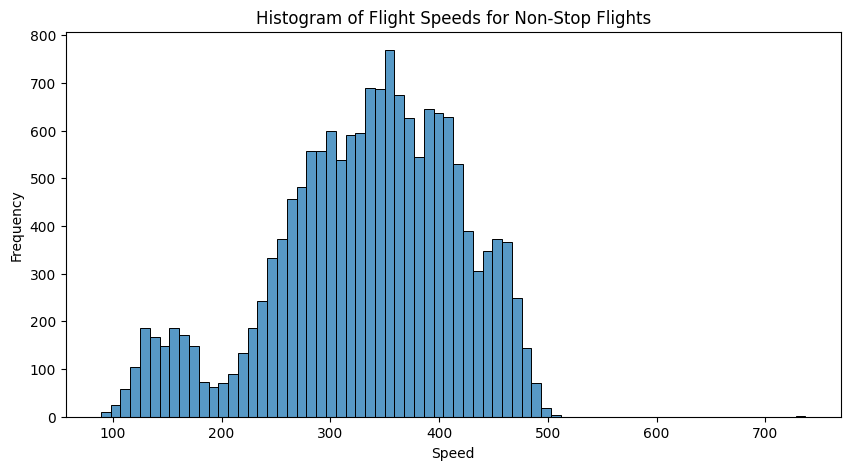

In [12]:
plt.figure(figsize=(10, 5))
sns.histplot(nonstop_df_final['Speed'])
plt.title("Histogram of Flight Speeds for Non-Stop Flights")
plt.xlabel("Speed")
plt.ylabel("Frequency")
plt.show()

It seems that overall distribution is approximately bell shaped though slightly left-skewed; most speeds fall between 250-450 mph with clear peak around 350 mph which is typical of commerical jet speeds. There is visible secondary bump at lower speeds around 150 mph which might be corresponding to regional or short-haul aircrafts. A few extreme values (beyond 600/700 mph) seems like outliers/anomalies.

#### Normality Check Using K-S Test

To test if the speed distribution is consistent with a normal distribution, we use the one-sample Kolmogorov-Smirnov (K-S) test. We perform this test for:

- **Boeing 737-800** airplane speeds
- **Delta** airline speeds

In each case, we:
- Filter the dataset to extract the relevant speeds
- Compute the sample mean and sample standard deviation
- Use these as parameters for the normal distribution
- Run the K-S test with a significance threshold of **0.05**

This allows us to statistically evaluate whether the data follows a normal distribution with its own empirical mean and variance.

In [13]:
# this function checks if the speed of flights for a given group is normally distributed using k-s test
def check_normality(df, group_col, group_name):
    speeds = df[df[group_col] == group_name]['Speed']
    mean, std = speeds.mean(), speeds.std()
    ks_stat, p_value = kstest(speeds, 'norm', args=(mean, std))

    result = "likely normal" if p_value > 0.05 else "likely not normal"
    return [group_name, f"{ks_stat:.5f}", f"{p_value:.2e}", result]

In [14]:
results = []

results.append(check_normality(nonstop_df_final, 'Airplane Type', 'Boeing 737-800'))
results.append(check_normality(nonstop_df_final, 'Airline', 'Delta'))

headers = ["Group", "KS Statistic", "p-value", "Conclusion"]
print(tabulate(results, headers=headers, tablefmt="grid"))

+----------------+----------------+-----------+-------------------+
| Group          |   KS Statistic |   p-value | Conclusion        |
+================+================+===========+===================+
| Boeing 737-800 |        0.05107 |  2.3e-05  | likely not normal |
+----------------+----------------+-----------+-------------------+
| Delta          |        0.03488 |  0.000443 | likely not normal |
+----------------+----------------+-----------+-------------------+


#### Comparing Distributions: 2-Sample Tests

To compare whether two different types of flights have similar speed distributions, we perform both:

- **2-sample Kolmogorov-Smirnov (K-S) test**, which compares their empirical cumulative distributions
- **Permutation test**, which tests whether the observed difference in distributions could have occurred by chance

We apply these tests to compare:
- **Boeing 737-800 vs Boeing 737-900**
- **Delta vs American Airlines**

This will help us determine whether the observed differences in speeds are statistically significant or not.

In [15]:
# function to do permutation testing in order to check if the means of two groups are significantly different
def permutation_test(sample1, sample2, num_permutations=10000):
    combined = np.concatenate([sample1, sample2])
    n1 = len(sample1)
    n2 = len(sample2)
    observed_diff = abs(sample1.mean() - sample2.mean())
    count = 0

    for _ in range(num_permutations):
        np.random.shuffle(combined)
        new_sample1 = combined[:n1]
        new_sample2 = combined[n1:]
        new_diff = abs(new_sample1.mean() - new_sample2.mean())
        if new_diff > observed_diff: # using strictly greater than because professor used strictly greater than in class
            count += 1

    return count / num_permutations

In [16]:
# function to check if the distributions of two groups are significantly different
def test_difference_in_distributions(df, group_col, group1, group2):
    speeds1 = df[df[group_col] == group1]['Speed']
    speeds2 = df[df[group_col] == group2]['Speed']

    ks_stat, ks_p_value = ks_2samp(speeds1, speeds2)
    perm_p_value = permutation_test(speeds1, speeds2)

    ks_result = "likely different distributions of speeds" if ks_p_value < 0.05 else "likely not different distributions of speeds"
    perm_result = "likely different distributions of speeds" if perm_p_value < 0.05 else "likely not different distributions of speeds"

    return [f"{group1} vs {group2}", f"{ks_stat:.4f}", f"{ks_p_value:.2e}", ks_result, f"{perm_p_value:.2e}", perm_result]

In [17]:
results = []

results.append(test_difference_in_distributions(nonstop_df_final, 'Airplane Type', 'Boeing 737-800', 'Boeing 737-900'))
results.append(test_difference_in_distributions(nonstop_df_final, 'Airline', 'Delta', 'American Airlines'))

headers = ["Group Comparison", "KS Stat", "KS p-value", "KS Result", "Perm p-value", "Perm Result"]
print(tabulate(results, headers=headers, tablefmt="grid"))

+----------------------------------+-----------+--------------+------------------------------------------+----------------+------------------------------------------+
| Group Comparison                 |   KS Stat |   KS p-value | KS Result                                |   Perm p-value | Perm Result                              |
+==================================+===========+==============+==========================================+================+==========================================+
| Boeing 737-800 vs Boeing 737-900 |    0.1666 |     1.48e-18 | likely different distributions of speeds |              0 | likely different distributions of speeds |
+----------------------------------+-----------+--------------+------------------------------------------+----------------+------------------------------------------+
| Delta vs American Airlines       |    0.1072 |     2.91e-19 | likely different distributions of speeds |              0 | likely different distributions of speeds 

### (v) Compare Speeds for Airplane Types, Airlines, and Routes

In this part, we perform hypothesis tests (Wald's Test, Z-test and T-test) to compare flight speeds across different airplane types, airlines, and route categories.

In [18]:
def walds_test(mean1, mean2, var1, var2, n1, n2):
    # using sample mean as estimator
    w_stat = abs(mean1 - mean2) / np.sqrt((var1 / n1) + (var2 / n2))
    p_val = 2 * (1 - norm.cdf(w_stat))
    return w_stat, p_val

In [19]:
def z_test(mean1, mean2, var1, var2, n1, n2):
    # treating sample variance as true variance
    z_stat = abs(mean1 - mean2) / np.sqrt((var1 / n1) + (var2 / n2))
    p_val = 2 * (1 - norm.cdf(z_stat))
    return z_stat, p_val

In [20]:
def perform_all_tests(sample1, sample2):
    mean1 = sample1.mean()
    mean2 = sample2.mean()
    var1 = sample1.var()
    var2 = sample2.var()
    n1 = len(sample1)
    n2 = len(sample2)

    wald_stat, wald_p_val = walds_test(mean1, mean2, var1, var2, n1, n2) # perform wald's test and get the statistic and p-value
    z_stat, z_p_val = z_test(mean1, mean2, var1, var2, n1, n2) # perform z-test and get the statistic and p-value
    t_stat, t_p_val = ttest_ind(sample1, sample2, equal_var=False) # perform t-test and get the statistic and p-value

    return {
        'Walds Test': (wald_stat, wald_p_val),
        'Z Test': (z_stat, z_p_val),
        'T Test': (abs(t_stat), t_p_val) # using absolute value for consistency
    } 

In [21]:
# function to check if the distributions of two groups are significantly different
def compare_groups(df, column, groups):
    if column == 'Airline':
        combinations = [('Delta', 'American Airlines'), ('Delta', 'Alaska Airlines'), ('JetBlue Airways', 'Delta')]
    else:
        combinations = it.combinations(groups, 2)

    for g1, g2 in combinations:
        speeds1 = df[df[column] == g1]['Speed']
        speeds2 = df[df[column] == g2]['Speed']
        test_results = perform_all_tests(speeds1, speeds2)

        print(f"\n====== {g1} vs {g2} ======")
        table = []
        headers = ["Test", "Statistic", "p-value", "Conclusion"]
        for test_name, (stat, p_val) in test_results.items():
            conclusion = "likely different speeds" if p_val < 0.05 else "likely not different speeds"
            table.append([test_name, f"{stat:.4f}", f"{p_val:.2e}", conclusion])
        print(tabulate(table, headers=headers, tablefmt="grid"))

#### 1. Airplane Type Comparisons

We consider the following four airplane types:
- Boeing 737-800
- Boeing 737-900
- Airbus A321
- Airbus A320

There are 6 unique pairs among these. For each pair, we:
- Compare their average speeds
- Conduct three different statistical tests:
  - **Wald's test** using sample means as estimators
  - **Z-test** assuming known (i.e sample) variance
  - **T-test** assuming unknown variance

We perform all tests assuming the standard assumptions of normality, independence, and equal variance where applicable. For each test, we also reflect on whether these assumptions seem to hold in practice.

For consistency, we use the critical value based on **z-scores** for all tests, even in the case of the t-test.

In [22]:
airplane_types = ['Boeing 737-800', 'Boeing 737-900', 'Airbus A321', 'Airbus A320']
compare_groups(nonstop_df_final, 'Airplane Type', airplane_types)


====== Boeing 737-800 vs Boeing 737-900 ======
+------------+-------------+-----------+-------------------------+
| Test       |   Statistic |   p-value | Conclusion              |
+============+=============+===========+=========================+
| Walds Test |      6.3785 |  1.79e-10 | likely different speeds |
+------------+-------------+-----------+-------------------------+
| Z Test     |      6.3785 |  1.79e-10 | likely different speeds |
+------------+-------------+-----------+-------------------------+
| T Test     |      6.3785 |  2.22e-10 | likely different speeds |
+------------+-------------+-----------+-------------------------+

====== Boeing 737-800 vs Airbus A321 ======
+------------+-------------+-----------+-------------------------+
| Test       |   Statistic |   p-value | Conclusion              |
+============+=============+===========+=========================+
| Walds Test |      9.1792 |  0        | likely different speeds |
+------------+-------------+--------

#### 2. Airline Comparisons

We repeat the same hypothesis tests (Wald's test, Z-test, and T-test) for the following airline pairs:
- American Airlines vs Delta
- Delta vs Alaska Airlines
- JetBlue Airlines vs Delta (using JetBlue Airways since data denotes JetBlue Airlines by JetBlue Airways)

This helps us understand whether there are significant differences in speed patterns across airlines.

In [23]:
airlines = ['American Airlines', 'Delta', 'Alaska Airlines', 'JetBlue Airways']
compare_groups(nonstop_df_final, 'Airline', airlines)


====== Delta vs American Airlines ======
+------------+-------------+-----------+-------------------------+
| Test       |   Statistic |   p-value | Conclusion              |
+============+=============+===========+=========================+
| Walds Test |      4.6098 |  4.03e-06 | likely different speeds |
+------------+-------------+-----------+-------------------------+
| Z Test     |      4.6098 |  4.03e-06 | likely different speeds |
+------------+-------------+-----------+-------------------------+
| T Test     |      4.6098 |  4.1e-06  | likely different speeds |
+------------+-------------+-----------+-------------------------+

====== Delta vs Alaska Airlines ======
+------------+-------------+-----------+-------------------------+
| Test       |   Statistic |   p-value | Conclusion              |
+============+=============+===========+=========================+
| Walds Test |     15.0174 |  0        | likely different speeds |
+------------+-------------+-----------+-------

#### 3. Route Type Comparisons (Based on Flight Distance)

We categorize the dataset into three route types:
- **Short-haul**: distance < 1000 miles
- **Medium-haul**: 1000 ≤ distance ≤ 2200 miles
- **Long-haul**: distance > 2200 miles

We then test for differences in average speeds across the following pairs of route categories:
- Short-haul vs Medium-haul
- Medium-haul vs Long-haul
- Short-haul vs Long-haul

Again, we apply all three tests (Wald's test, Z-test, and T-test) and assess the validity of the assumptions made for each.

In [24]:
def label_route(distance):
    if distance < 1000:
        return 'Short'
    elif distance < 2200:
        return 'Medium'
    else:
        return 'Long'
    
nonstop_df_final['Route Type'] = nonstop_df_final['Distance'].apply(label_route)

In [25]:
route_types = nonstop_df_final['Route Type'].unique()
compare_groups(nonstop_df_final, 'Route Type', route_types)


====== Short vs Medium ======
+------------+-------------+-----------+-------------------------+
| Test       |   Statistic |   p-value | Conclusion              |
+============+=============+===========+=========================+
| Walds Test |      128.96 |         0 | likely different speeds |
+------------+-------------+-----------+-------------------------+
| Z Test     |      128.96 |         0 | likely different speeds |
+------------+-------------+-----------+-------------------------+
| T Test     |      128.96 |         0 | likely different speeds |
+------------+-------------+-----------+-------------------------+

====== Short vs Long ======
+------------+-------------+-----------+-------------------------+
| Test       |   Statistic |   p-value | Conclusion              |
+============+=============+===========+=========================+
| Walds Test |     162.765 |         0 | likely different speeds |
+------------+-------------+-----------+-------------------------+
| 

By running these tests, we were able to draw clear conclusions about whether speeds were different across airplane types, airlines, and route categories. TAs can check that in output cells above.